# SMS Spam Collection Deep Learning



- Github Repo: https://github.com/GHeart01/SMS-Spam-Collection-Deep-Learning
- Youtube: 

### Table of Contents
- [Description](#Description)
- [EDA](#Exploratory-Data-Analysis)
- [Model](#Model)
- [Hypertuning](#Hypertuning)
- [Results and Analysis](#Results-and-Analysis)
- [Conclusion](#Conclusion)
- [Citation](#Citation)

### Description

In this project my goal is to build a model to predict which text messages are spam. The messages are classified as ham (legitimate) or spam. The Kaggle decription specifies ham 4825 messages and 747 spam SMS messages. A set of 3375 messages have been chosen as ham messages, a subset of about 10,000 messages from NUS SMS Corpus (NSC).

Here I approach the problem with a quick look at the data, and determine if a transformation needs to be made on the data.

### Exploratory Data Analysis

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv("spam.csv", encoding = 'latin-1') # consider non UTF-8 bits
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


Despite the df head and tail appear to have only null values in column 3,4, and 5 we can see from df.info this is not the case. I'm going to investiage why they were included in the data set.

In [4]:
# Check what's in Unnamed: 2 (50 non-null values)
print("Unnamed: 2 column analysis:")
unnamed_2_data = df['Unnamed: 2'].dropna()
print(f"Value counts:")
print(unnamed_2_data.value_counts().head(10))

# Check what's in Unnamed: 3 (12 non-null values)
print("\nUnnamed: 3 column analysis:")
unnamed_3_data = df['Unnamed: 3'].dropna()
print(f"Value counts:")
print(unnamed_3_data.value_counts().head(10))

# Check what's in Unnamed: 4 (6 non-null values)
print("\nUnnamed: 4 column analysis:")
unnamed_4_data = df['Unnamed: 4'].dropna()
print(f"Value counts:")
print(unnamed_4_data.value_counts().head(10))


Unnamed: 2 column analysis:
Value counts:
Unnamed: 2
 bt not his girlfrnd... G o o d n i g h t . . .@"            3
 PO Box 5249                                                 2
this wont even start........ Datz confidence.."              2
GN                                                           2
 don't miss ur best life for anything... Gud nyt..."         2
 but dont try to prove it..\" .Gud noon...."                 2
 Gud night...."                                              1
 like you are the KING\"...! OR \"Walk like you Dont care    1
 HAD A COOL NYTHO                                            1
 PO Box 1146 MK45 2WT (2/3)"                                 1
Name: count, dtype: int64

Unnamed: 3 column analysis:
Value counts:
Unnamed: 3
 MK17 92H. 450Ppw 16"                         2
GE                                            2
 why to miss them                             1
U NO THECD ISV.IMPORTANT TOME 4 2MORO\""      1
i wil tolerat.bcs ur my someone..... But     

It appears that unnamed cloumns 2, 3, and 4 contain message endings for very long texts, quotes, Addresses, and a lot of misspelled words. I will keep this data in the dataframe as they may be indicators of spam. 

#### Feature engineering

I am going to split the data into new features to gain a better analysis on the dataframe. Currently the columns are fairly undecriptive, so I have added features: message_length, word_count, uppercase_count, exclamation_count, question_count, dollar_count, digit_count, and url_count. 

In [5]:
# Rename columns for clarity
df_analysis = df.copy()
df_analysis.columns = ['label', 'message', 'extra_field_1', 'extra_field_2', 'extra_field_3'] 
# replacing "unnamed" with "extra_field" when decribing df copy : df_analysis

# Create binary indicators for presence of extra fields
df_analysis['has_extra_field_1'] = df_analysis['extra_field_1'].notna().astype(int)
df_analysis['has_extra_field_2'] = df_analysis['extra_field_2'].notna().astype(int)
df_analysis['has_extra_field_3'] = df_analysis['extra_field_3'].notna().astype(int)

# Basic text features from main message
df_analysis['message_length'] = df_analysis['message'].str.len()
df_analysis['word_count'] = df_analysis['message'].str.split().str.len()
df_analysis['uppercase_count'] = df_analysis['message'].str.count(r'[A-Z]')
df_analysis['exclamation_count'] = df_analysis['message'].str.count('!')
df_analysis['question_count'] = df_analysis['message'].str.count(r'\?')
df_analysis['dollar_count'] = df_analysis['message'].str.count(r'\$')
df_analysis['digit_count'] = df_analysis['message'].str.count(r'\d')
df_analysis['url_count'] = df_analysis['message'].str.count(r'http[s]?://|www\.')

# Add extra field lengths where available
df_analysis['extra_field_1_length'] = df_analysis['extra_field_1'].str.len().fillna(0)
df_analysis['extra_field_2_length'] = df_analysis['extra_field_2'].str.len().fillna(0)
df_analysis['extra_field_3_length'] = df_analysis['extra_field_3'].str.len().fillna(0)

In [6]:
# Encode labels
le = LabelEncoder()
df_analysis['label_encoded'] = le.fit_transform(df_analysis['label'])

print(f"Total features created: {len([col for col in df_analysis.columns if col not in ['label', 'message', 'extra_field_1', 'extra_field_2', 'extra_field_3']])}")

Total features created: 15


In [7]:
# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig = plt.figure(figsize=(24, 20))

<Figure size 2400x2000 with 0 Axes>

In [8]:
# Label Distribution
label_counts = df_analysis['label'].value_counts()
print("Label distribution:")
print(label_counts)
print(f"\nSpam percentage: {(label_counts.get('spam', 0) / len(df_analysis)) * 100:.2f}%")

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Spam percentage: 13.41%


Taking a look at the original unnamed columns, we can see high spam rates in unnammed column 1 and 2.

In [9]:
extra_field_stats = pd.DataFrame({
    'Extra Field 1': df_analysis.groupby('label')['has_extra_field_1'].sum(),
    'Extra Field 2': df_analysis.groupby('label')['has_extra_field_2'].sum(),
    'Extra Field 3': df_analysis.groupby('label')['has_extra_field_3'].sum()
})
print("Extra fields presence by label:")
print(extra_field_stats)

Extra fields presence by label:
       Extra Field 1  Extra Field 2  Extra Field 3
label                                             
ham               45             10              6
spam               5              2              0


In [10]:
print(f'spam rate in unnamed column 1: {5/50 * 100}%')
print(f'spam rate in unnamed column 2: {2/10 * 100}%')
print(f'spam rate in unnamed column 3: {0 * 100}%')

spam rate in unnamed column 1: 10.0%
spam rate in unnamed column 2: 20.0%
spam rate in unnamed column 3: 0%


[None, None]

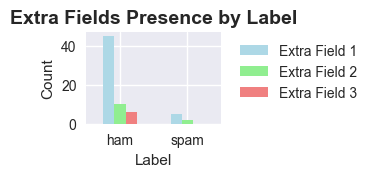

In [11]:
# Extra fields analysis plot
EFAP = plt.subplot(4, 4, 2)
extra_field_stats.plot(kind='bar', ax=EFAP, color=['lightblue', 'lightgreen', 'lightcoral'])
EFAP.set_title('Extra Fields Presence by Label', fontsize=14, fontweight='bold')
EFAP.set_ylabel('Count')
EFAP.set_xlabel('Label')
EFAP.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(EFAP.xaxis.get_majorticklabels(), rotation=0)

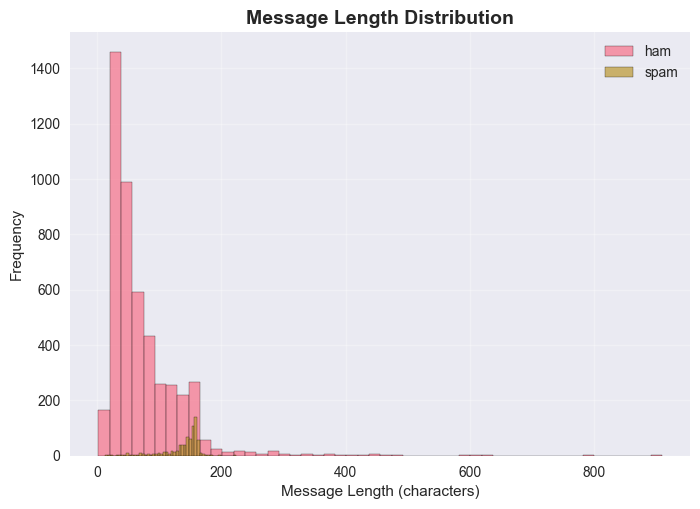

In [12]:
Message_length_dis = plt.subplot(1, 1, 1)
for label in df_analysis['label'].unique():
    data = df_analysis[df_analysis['label'] == label]['message_length']
    Message_length_dis.hist(data, alpha=0.7, label=label, bins=50, edgecolor='black')
Message_length_dis.set_title('Message Length Distribution', fontsize=14, fontweight='bold')
Message_length_dis.set_xlabel('Message Length (characters)')
Message_length_dis.set_ylabel('Frequency')
Message_length_dis.legend()
Message_length_dis.grid(True, alpha=0.3)

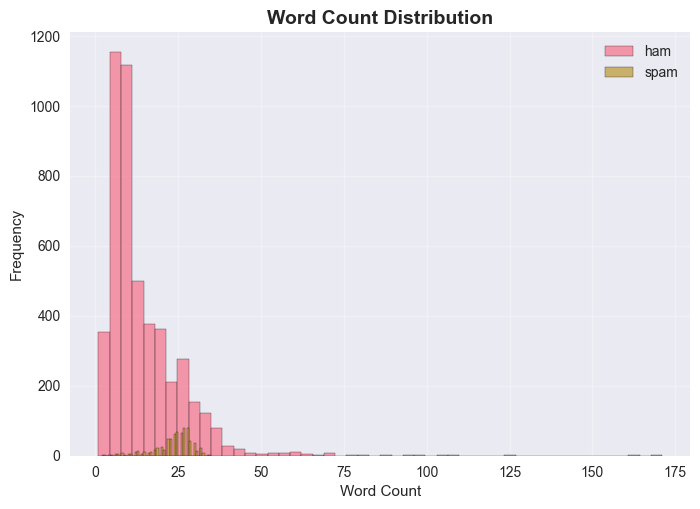

In [13]:
Word_Count = plt.subplot(1, 1, 1)
for label in df_analysis['label'].unique():
    data = df_analysis[df_analysis['label'] == label]['word_count']
    Word_Count.hist(data, alpha=0.7, label=label, bins=50, edgecolor='black')
Word_Count.set_title('Word Count Distribution', fontsize=14, fontweight='bold')
Word_Count.set_xlabel('Word Count')
Word_Count.set_ylabel('Frequency')
Word_Count.legend()
Word_Count.grid(True, alpha=0.3)

Text(0.5, 0.98, '')

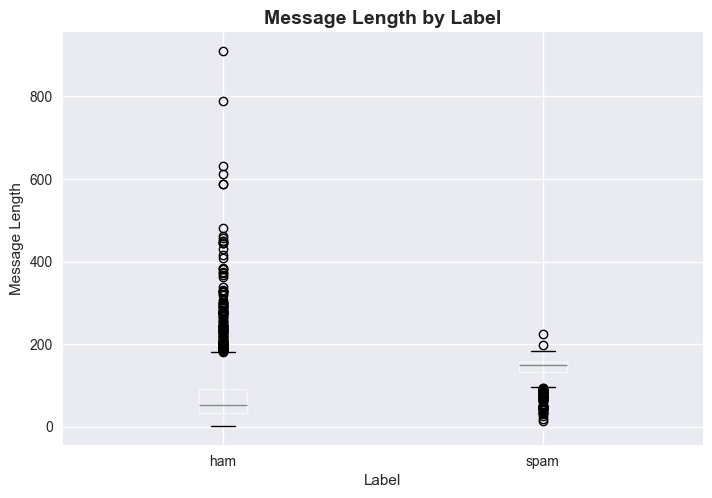

In [14]:
Mess_Len = plt.subplot(1, 1, 1)
df_analysis.boxplot(column='message_length', by='label', ax=Mess_Len)
Mess_Len.set_title('Message Length by Label', fontsize=14, fontweight='bold')
Mess_Len.set_xlabel('Label')
Mess_Len.set_ylabel('Message Length')
plt.suptitle('')

#### UpperCase plot

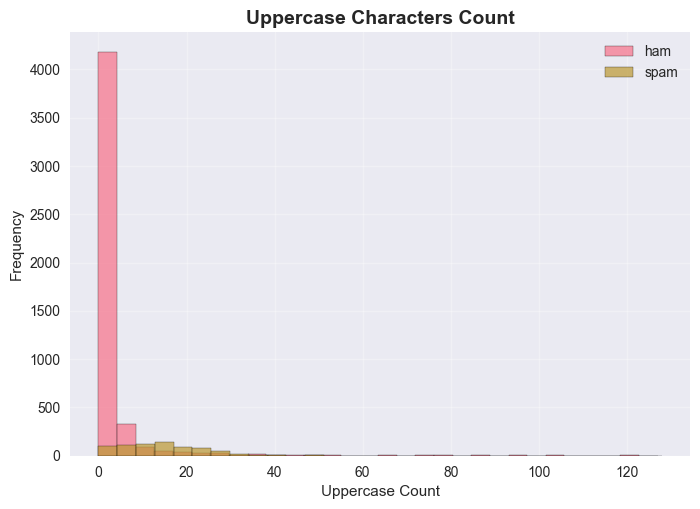

In [15]:
UC = plt.subplot(1, 1, 1)
for label in df_analysis['label'].unique():
    data = df_analysis[df_analysis['label'] == label]['uppercase_count']
    UC.hist(data, alpha=0.7, label=label, bins=30, edgecolor='black')
UC.set_title('Uppercase Characters Count', fontsize=14, fontweight='bold')
UC.set_xlabel('Uppercase Count')
UC.set_ylabel('Frequency')
UC.legend()
UC.grid(True, alpha=0.3)

#### Speical Characters Scatter plot ( ! vs. $

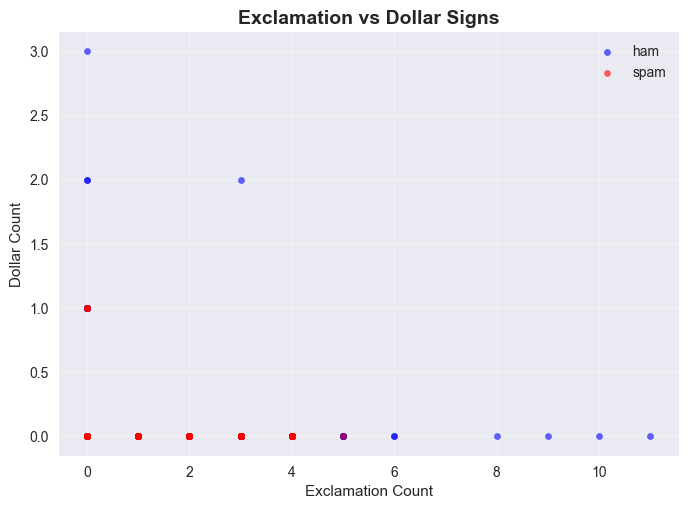

In [16]:
# Special characters scatter
sp = plt.subplot(1, 1, 1)
colors = {'ham': 'blue', 'spam': 'red'}
for label in df_analysis['label'].unique():
    data = df_analysis[df_analysis['label'] == label]
    sp.scatter(data['exclamation_count'], data['dollar_count'], 
               c=colors.get(label, 'gray'), alpha=0.6, label=label, s=20)
sp.set_title('Exclamation vs Dollar Signs', fontsize=14, fontweight='bold')
sp.set_xlabel('Exclamation Count')
sp.set_ylabel('Dollar Count')
sp.legend()
sp.grid(True, alpha=0.3)

Surprisingly messages with more explaination points and dollar signs are LESS frequently marked as spam.

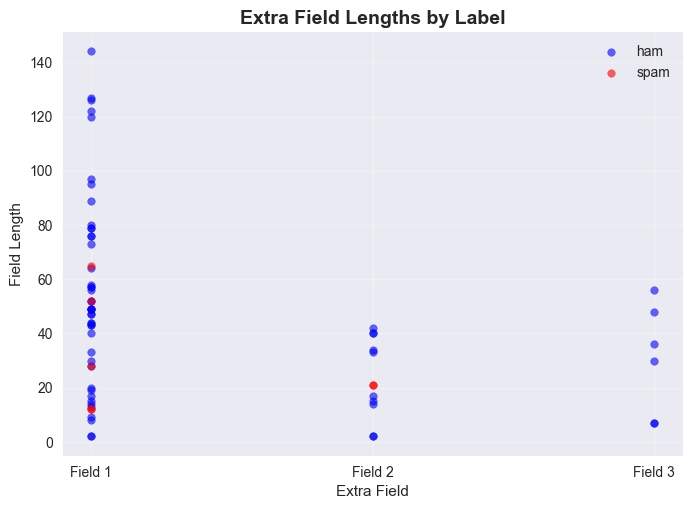

In [17]:
# Extra field lengths vs spam
ax9 = plt.subplot(1,1,1)
extra_lengths = ['extra_field_1_length', 'extra_field_2_length', 'extra_field_3_length']
for i, field in enumerate(extra_lengths):
    for label in df_analysis['label'].unique():
        data = df_analysis[df_analysis['label'] == label][field]
        data_nonzero = data[data > 0]  # Only non-zero lengths
        if len(data_nonzero) > 0:
            ax9.scatter([i] * len(data_nonzero), data_nonzero, 
                       c=colors.get(label, 'gray'), alpha=0.6, label=f'{label}' if i == 0 else "", s=30)
ax9.set_title('Extra Field Lengths by Label', fontsize=14, fontweight='bold')
ax9.set_xlabel('Extra Field')
ax9.set_ylabel('Field Length')
ax9.set_xticks([0, 1, 2])
ax9.set_xticklabels(['Field 1', 'Field 2', 'Field 3'])
if len(ax9.get_legend_handles_labels()[0]) > 0:
    ax9.legend()
ax9.grid(True, alpha=0.3)

In [18]:
# numeric columns for correlation
numeric_cols = ['message_length', 'word_count', 'uppercase_count', 'exclamation_count',
                'question_count', 'dollar_count', 'digit_count', 'url_count',
                'has_extra_field_1', 'has_extra_field_2', 'has_extra_field_3',
                'extra_field_1_length', 'extra_field_2_length', 'extra_field_3_length',
                'label_encoded']

correlation_matrix = df_analysis[numeric_cols].corr()
correlations_with_label = correlation_matrix['label_encoded'].sort_values(key=abs, ascending=False)

print("Correlation with spam label (1=spam, 0=ham):")
for feature, corr in correlations_with_label.items():
    if feature != 'label_encoded':
        print(f" {feature.replace('_', ' ').title()}: {corr:.4f}")

Correlation with spam label (1=spam, 0=ham):
 Digit Count: 0.8436
 Message Length: 0.3873
 Uppercase Count: 0.3511
 Url Count: 0.3342
 Word Count: 0.2903
 Exclamation Count: 0.2760
 Question Count: -0.0267
 Extra Field 1 Length: -0.0165
 Has Extra Field 3: -0.0129
 Extra Field 3 Length: -0.0110
 Has Extra Field 1: -0.0095
 Dollar Count: 0.0061
 Has Extra Field 2: 0.0044
 Extra Field 2 Length: 0.0018


This is a direct approach to the correlatoin of the new features, but I've also made a heatmap for a visual analysis

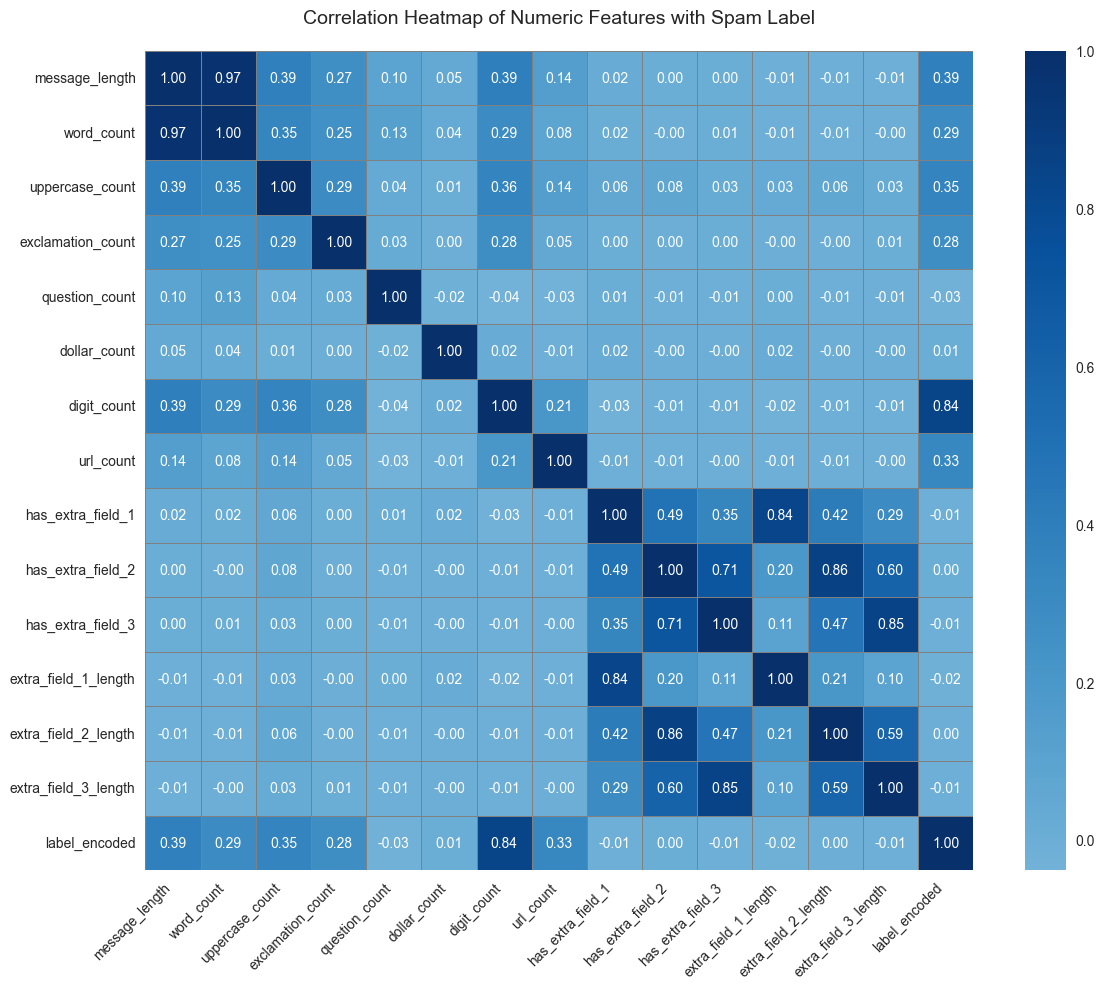

In [19]:
plt.figure(figsize=(12, 10))

# heatmap
heatmap = sns.heatmap(correlation_matrix, 
                      annot=True, 
                      fmt=".2f", 
                      cmap='Blues',
                      center=0,
                      linewidths=0.5,
                      linecolor='gray')

# plot
plt.title('Correlation Heatmap of Numeric Features with Spam Label', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

From the heatmap, and feature analysis:
- Digit Count: 0.8436
- Message Length: 0.3873
- Uppercase Count: 0.3511

there is very strong correlation between digit count and spam, as well as several other features. I will use this as a basis to trian the Deep learning model.

### Model

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


# Features (before log transform) no target variable
numeric_cols = ['message_length', 'word_count', 'uppercase_count', 'exclamation_count',
               'question_count', 'dollar_count', 'digit_count', 'url_count',
               'has_extra_field_1', 'has_extra_field_2', 'has_extra_field_3',
               'extra_field_1_length', 'extra_field_2_length', 'extra_field_3_length']

I am going to test out 2 models and compare them against each other. I have removed the target variable for these models.
#### Deep Neural Network (DNN)

In [21]:
df_DNN = df_analysis.copy()

In [22]:
X = df_DNN[numeric_cols].values
y = df_DNN['label_encoded'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (critical for DNNs)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build DNN model
model_dnn = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_dnn = model_dnn.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate
y_pred_dnn = (model_dnn.predict(X_test_scaled) > 0.5).astype(int)
print("DNN Performance:")
print(classification_report(y_test, y_pred_dnn))

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8794 - loss: 0.3898 - val_accuracy: 0.9709 - val_loss: 0.0900
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.9686 - loss: 0.0934 - val_accuracy: 0.9720 - val_loss: 0.0926
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.9757 - loss: 0.0727 - val_accuracy: 0.9731 - val_loss: 0.0962
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.9798 - loss: 0.0686 - val_accuracy: 0.9731 - val_loss: 0.0918
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.9764 - loss: 0.0682 - val_accuracy: 0.9742 - val_loss: 0.0888
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.9761 - loss: 0.0699 - val_accuracy: 0.9731 - val_loss: 0.0990
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.9744 - loss: 0.0677 - val_accuracy: 0.9731 - val_loss: 0.0990
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.9801 - loss: 0.0626 - va

<Axes: >

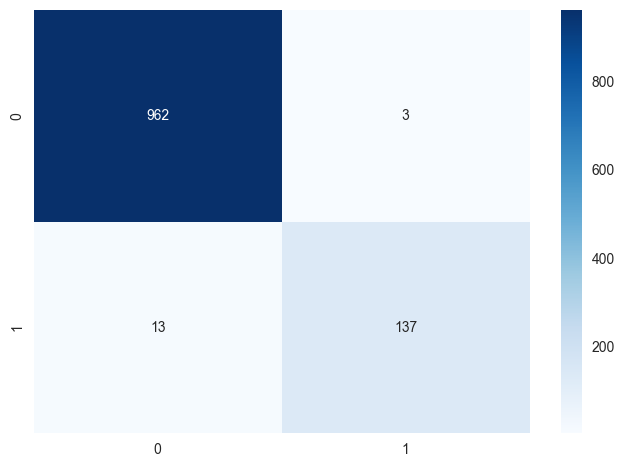

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_dnn)
sns.heatmap(cm,
            annot=True,
            cmap=sns.color_palette("Blues", as_cmap=True),
            fmt='d')

Here we see low off diagonal values which is very good!

#### Long Short Term Memory (LSTM)

In [24]:
df_LSTM = df_analysis.copy()

In [25]:
# Reshape data for LSTM (samples, timesteps, features)

X = df_LSTM[numeric_cols].values
y = df_LSTM['label_encoded'].values
# Assuming each feature is a "timestep"
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build LSTM model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(1, X_train.shape[1])),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_lstm = model_lstm.fit(
    X_train_reshaped, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate
y_pred_lstm = (model_lstm.predict(X_test_reshaped) > 0.5).astype(int)
print("LSTM Performance:")
print(classification_report(y_test, y_pred_lstm))

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8048 - loss: 0.6051 - val_accuracy: 0.9439 - val_loss: 0.3258
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.9532 - loss: 0.2636 - val_accuracy: 0.9720 - val_loss: 0.1417
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.9692 - loss: 0.1228 - val_accuracy: 0.9731 - val_loss: 0.1003
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.9732 - loss: 0.0925 - val_accuracy: 0.9709 - val_loss: 0.0894
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.9708 - loss: 0.0872 - val_accuracy: 0.9709 - val_loss: 0.0860
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.9743 - loss: 0.0817 - val_accuracy: 0.9731 - val_loss: 0.0839
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.9761 - loss: 0.0729 - val_accuracy: 0.9742 - val_loss: 0.0831
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.9781 - loss: 0.0738 - va

<Axes: >

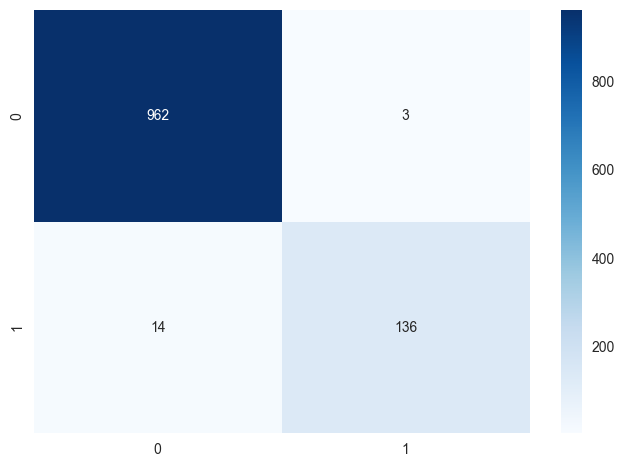

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm,
            annot=True,
            cmap=sns.color_palette("Blues", as_cmap=True),
            fmt='d')

Here Ham is class 0 and Spam is class 1. Before any hypertuning I achieved 99% and 98% accuracy, which is already extremely high, but lets see if a log transformation makes any possitive changes. 

#### Hypertuning
I am going to take a look at performing a log transformation on my df_analysis to determine if performance improves.

#### Numeric Feature Analysis

Here I analysis which features if any should a have a transformation

In [27]:
# DISTRIBUTION ANALYSIS FOR LOG TRANSFORMATION

def analyze_distribution(data, feature_name):
    data_clean = data[data >= 0]  # Remove negative values if any
    data_no_zeros = data_clean[data_clean > 0]
    
    if len(data_clean) == 0:
        return {'skewness': np.nan, 'p_value': np.nan, 'log_recommended': False, 'log_skewness': np.nan}
    
    skewness = stats.skew(data_clean)
    
    # Test for normality
    if len(data_clean) < 5000:
        _, p_value = stats.shapiro(data_clean[:5000])
    else:
        _, p_value = stats.normaltest(data_clean)
    
    # Test log transformation
    log_recommended = False
    log_skewness = np.nan
    if len(data_no_zeros) > 0:
        log_data = np.log1p(data_no_zeros)
        log_skewness = stats.skew(log_data)
        
        if abs(log_skewness) < abs(skewness) * 0.7 and abs(skewness) > 1:
            log_recommended = True
    
    return {
        'skewness': skewness,
        'p_value': p_value,
        'log_recommended': log_recommended,
        'log_skewness': log_skewness
    }

In [28]:
features_to_analyze = [col for col in numeric_cols if col != 'label_encoded']

print(f"{'Feature':<25} {'Skewness':<12}  {'Log Skew':<12}")
print("-" * 55)

log_recommended_features = []
for feature in features_to_analyze:
    analysis = analyze_distribution(df_analysis[feature], feature)
    log_skew = f"{analysis['log_skewness']:.3f}" if not np.isnan(analysis['log_skewness']) else "N/A"
    
    if analysis['log_recommended']:
        log_recommended_features.append(feature)
    
    print(f"{feature:<25} {analysis['skewness']:<12.3f}  {log_skew:<12}")



Feature                   Skewness      Log Skew    
-------------------------------------------------------
message_length            2.512         -0.210      
word_count                2.694         -0.062      
uppercase_count           5.611         1.492       
exclamation_count         4.607         1.790       
question_count            4.421         3.024       
dollar_count              23.371        1.667       
digit_count               3.007         0.218       
url_count                 8.157         2.598       
has_extra_field_1         10.414        N/A         
has_extra_field_2         21.479        N/A         
has_extra_field_3         30.425        N/A         
extra_field_1_length      15.260        -1.129      
extra_field_2_length      27.655        -1.179      
extra_field_3_length      39.532        -0.530      


Based on

    log_skewness = np.nan
    if len(data_no_zeros) > 0:
        log_data = np.log1p(data_no_zeros)
        log_skewness = stats.skew(log_data)
        
        if abs(log_skewness) < abs(skewness) * 0.7 and abs(skewness) > 1:
            log_recommended = True

I have decided to apply a log transformation on every numeric feature

In [29]:
df_log = df_analysis.copy()

# Apply log1p (log(x+1)) to skewed features (from your skewness analysis)
skewed_features = ['message_length', 'word_count', 'uppercase_count', 'exclamation_count',
                  'question_count', 'dollar_count', 'digit_count', 'url_count',
                  'extra_field_1_length', 'extra_field_2_length', 'extra_field_3_length']

for feature in skewed_features:
    df_log[f'log_{feature}'] = np.log1p(df_log[feature])  # log1p handles zeros

# Drop original skewed features (keep binary/categorical features)
df_log.drop(columns=skewed_features, inplace=True)
df_log

,label,message,extra_field_1,extra_field_2,extra_field_3,has_extra_field_1,has_extra_field_2,has_extra_field_3,label_encoded,log_message_length,log_word_count,log_uppercase_count,log_exclamation_count,log_question_count,log_dollar_count,log_digit_count,log_url_count,log_extra_field_1_length,log_extra_field_2_length,log_extra_field_3_length
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,0,0,0,0,4.718499,3.044522,1.386294,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,0,0,0,0,3.401197,1.945910,1.098612,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,0,0,0,1,5.049856,3.367296,2.397895,0.000000,0.000000,0.0,3.258097,0.0,0.0,0.0,0.0
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,0,0,0,0,3.912023,2.484907,1.098612,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,0,0,0,0,4.127134,2.639057,1.098612,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN,0,0,0,1,5.087596,3.433987,2.302585,0.693147,0.000000,0.0,3.091042,0.0,0.0,0.0,0.0
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN,0,0,0,0,3.637586,2.197225,0.693147,0.000000,0.693147,0.0,0.000000,0.0,0.0,0.0,0.0
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN,0,0,0,0,4.060443,2.397895,1.098612,0.000000,0.693147,0.0,0.000000,0.0,0.0,0.0,0.0
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN,0,0,0,0,4.836282,3.295837,1.098612,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


#### Preprocess

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features (now log-transformed)
log_numeric_cols = [col for col in df_log.columns if col.startswith('log_')] + \
                  ['has_extra_field_1', 'has_extra_field_2', 'has_extra_field_3']

X_log = df_log[log_numeric_cols].values
y_log = df_log['label_encoded'].values

# Train-test split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

# Standardize 
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log)
X_test_log_scaled = scaler_log.transform(X_test_log)

#### DNN Log Transformed

In [31]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Build the same DNN architecture
model_dnn_log = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_log.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_dnn_log.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_dnn_log = model_dnn_log.fit(
    X_train_log_scaled, y_train_log,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate
y_pred_dnn_log = (model_dnn_log.predict(X_test_log_scaled) > 0.5).astype(int)
print("DNN (Log-Transformed Features) Performance:")
print(classification_report(y_test_log, y_pred_dnn_log))

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9085 - loss: 0.3298 - val_accuracy: 0.9765 - val_loss: 0.0910
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.9718 - loss: 0.0897 - val_accuracy: 0.9787 - val_loss: 0.1001
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.9706 - loss: 0.0947 - val_accuracy: 0.9776 - val_loss: 0.0924
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.9742 - loss: 0.0852 - val_accuracy: 0.9765 - val_loss: 0.0964
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.9709 - loss: 0.0902 - val_accuracy: 0.9765 - val_loss: 0.0961
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.9780 - loss: 0.0648 - val_accuracy: 0.9776 - val_loss: 0.0894
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.9772 - loss: 0.0734 - val_accuracy: 0.9787 - val_loss: 0.0946
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.9786 - loss: 0.0806 - va

<Axes: >

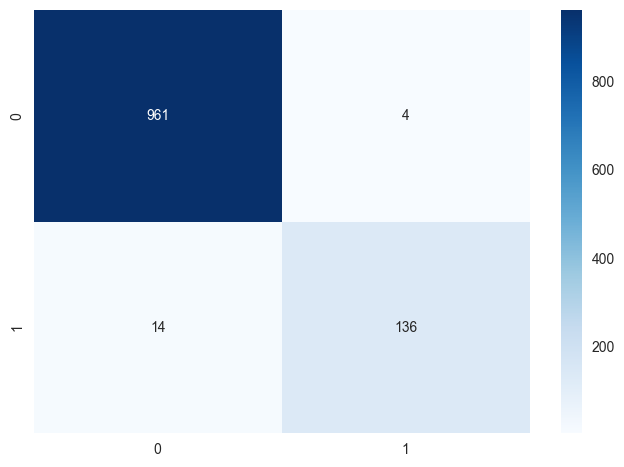

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_dnn_log)
sns.heatmap(cm,
            annot=True,
            cmap=sns.color_palette("Blues", as_cmap=True),
            fmt='d')

#### LSTM Log Transformed

In [33]:
# Reshape for LSTM (samples, timesteps, features)
X_train_log_reshaped = X_train_log_scaled.reshape(X_train_log_scaled.shape[0], 1, X_train_log_scaled.shape[1])
X_test_log_reshaped = X_test_log_scaled.reshape(X_test_log_scaled.shape[0], 1, X_test_log_scaled.shape[1])

# Build the same LSTM architecture
model_lstm_log = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(1, X_train_log.shape[1])),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm_log.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_lstm_log = model_lstm_log.fit(
    X_train_log_reshaped, y_train_log,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate
y_pred_lstm_log = (model_lstm_log.predict(X_test_log_reshaped) > 0.5).astype(int)
print("LSTM (Log-Transformed Features) Performance:")
print(classification_report(y_test_log, y_pred_lstm_log))

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8291 - loss: 0.5811 - val_accuracy: 0.9406 - val_loss: 0.3108
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.9422 - loss: 0.2563 - val_accuracy: 0.9742 - val_loss: 0.1368
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.9670 - loss: 0.1271 - val_accuracy: 0.9798 - val_loss: 0.0952
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.9767 - loss: 0.0903 - val_accuracy: 0.9753 - val_loss: 0.0849
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.9766 - loss: 0.0745 - val_accuracy: 0.9765 - val_loss: 0.0823
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.9738 - loss: 0.0769 - val_accuracy: 0.9765 - val_loss: 0.0814
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.9721 - loss: 0.0784 - val_accuracy: 0.9776 - val_loss: 0.0807
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.9747 - loss: 0.0756 - va

<Axes: >

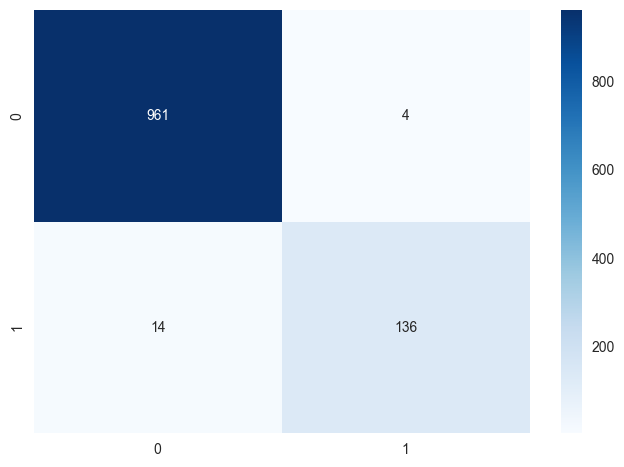

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_lstm_log)
sns.heatmap(cm,
            annot=True,
            cmap=sns.color_palette("Blues", as_cmap=True),
            fmt='d')

### Results and Analysis

In [39]:
print("DNN Performance:")
print(classification_report(y_test_log, y_pred_dnn))

print("DNN (Log-Transformed Features) Performance:")
print(classification_report(y_test_log, y_pred_dnn_log))

print("LSTM Performance:")
print(classification_report(y_test, y_pred_lstm))

print("LSTM (Log-Transformed Features) Performance:")
print(classification_report(y_test_log, y_pred_lstm_log))

DNN Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.98      0.91      0.94       150

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

DNN (Log-Transformed Features) Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.97      0.91      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

LSTM Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.98      0.91      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      

In all deep learning models, spam was identified at least 98% of the time, which is near perfect. Unfortunately log transformation did not significantly improve performance, but maintained a high accuracy. The non-log transformed and log transformed models all performed extremely well. The initial EDA in which I created the new features appears to have make a significant impact on improving model performance, as it would have been extremely difficult to train a model on the original data.

### Conclusion

The utilization of feature engineering to create skewed features allowed for a very comprehensive analysis both in EDA and model building. 98%+ accuracy was achieved in all models, which were all trained at 20 epochs. In the future I may gain more information from training at a smaller number of epoch to determine if I can achieve similar accuracy with a smaller number of iterations, but here the training data is small so I did not feel pressured to do so. Overall, I am very happy with performance of this model.

### Citation
Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

GÃ³mez Hidalgo, J.M., Cajigas Bringas, G., Puertas Sanz, E., Carrero GarcÃ­a, F. Content Based SMS Spam Filtering. Proceedings of the 2006 ACM Symposium on Document Engineering (ACM DOCENG'06), Amsterdam, The Netherlands, 10-13, 2006.

Cormack, G. V., GÃ³mez Hidalgo, J. M., and Puertas SÃ¡nz, E. Feature engineering for mobile (SMS) spam filtering.  Proceedings of the 30th Annual international ACM Conference on Research and Development in information Retrieval (ACM SIGIR'07), New York, NY, 871-872, 2007.

Cormack, G. V., GÃ³mez Hidalgo, J. M., and Puertas SÃ¡nz, E. Spam filtering for short messages. Proceedings of the 16th ACM Conference on Information and Knowledge Management (ACM CIKM'07). Lisbon, Portugal, 313-320, 2007.

SMS Spam Collection Dataset. (n.d.). Www.kaggle.com. https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data

(2011). SMS Spam Collection [Review of SMS Spam Collection]. Unicamp; dt. http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/
